# Example of data translation using a bijective graph
The graph method creates a series of interlocking nodes that have transformations between themselves. There are a few basic rules:
1. Any node has an edge into and out of itself
2. Any path that results in the same end location creates the same node 

## This example is one of a rectangular table, a set of column modeled data. 
### This graph has the folowing nodes, and hence transformations between all of them
1. n1, 'Pandas Data Frame', in memory 
2. n2, 'AsciiDataTable', in memory
3. n3, 'HDF File', on disk
4. n4, 'XML Data Table',in memory
5. n5, 'Excel File', on disk
6. n6, 'HTML String',in memory
7. n7, 'JSON File', on disk
8. n8, 'JSON String',in memory
9. n9,'CSV File', on disk
10. n10, 'Matlab File', on disk
11. n11, 'XML File', on disk
12. n12, 'HTML File ', on disk

### Naming of translation functions
The naming of functions that translate one data format to another should follow these rules
1. When a python class is involved the name should be the class name with the same structure
2. When an on disk format is chosen it should be all lower case with underscores
3. Names should be type_1_to_type_2()
4. File names should have a parameter that can be passed

Example:
>> DataFrame_to_AsciiDataTable



In [1]:
from pyMeasure import *
import pandas
from scipy.io import savemat,loadmat
import re
import datetime
import numpy as np
from ipywidgets import *
import json
import networkx
import odo
import sqlite3

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [71]:
def remove_circular_paths(path):
    """Removes pieces of the path that just end on the same node"""
    edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
    past_locations=[]
    
    for index,edge in enumerate(path):
        match=re.match(edge_pattern,edge)
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        past_locations.append(begin_node)
        #print("{0} is {1}".format("past_locations",past_locations))
    new_path=[]
    node_index=0
    between_list=[False for item in past_locations]
    while(node_index<len(past_locations)):
        node=past_locations[node_index]
        old_path=new_path
        new_path=[]
        
        if past_locations.count(node)>1:
            #print("{0} is {1}".format("node",node))
            #print("{0} is {1}".format("past_locations",past_locations))
            equality_list=map(lambda x:x==node,past_locations)
            #print("{0} is {1}".format("equality_list",equality_list))
            between=False
            for index,equality in enumerate(equality_list):
                if equality and equality_list[index:].count(True)%2==1:
                    between=not between
                    between_list[index]=between or between_list[index]
                else:
                    between_list[index]=between or between_list[index] 
        #print("{0} is {1}".format("between_list",between_list))
        for index,item in enumerate(between_list):
            if not item:
                new_path.append(path[index])
        node_index+=1

    if new_path in [[]]:
        new_path=path
                    
    return new_path

def edge_1_to_2(in_string):
    return in_string.splitlines()
    
def edge_2_to_1(string_list):
    return string_list_collapse(string_list)

class Graph():
    def __init__(self,**options):
        """Initializes the graph. The first 2 nodes and two edges forming a bijection between them are required"""
        defaults={"graph_name":"Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["A plain string",
                                       "A list of strings with no \\n, created with string.splitlines()"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":"This is a test string\n it has to have multiple lines \n and many characters 34%6\n^",
                  "edge_2_to_1":edge_2_to_1,
                  "edge_1_to_2":edge_1_to_2
                 }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        self.elements=['graph_name','node_names','node_descriptions','current_node','state','data']
        for element in self.elements:
            self.__dict__[element]=self.options[element]
        self.edges=[]
        self.edge_matrices=[]
        self.state_matrix=np.matrix(self.state).T
        # Add the first 2 edges, required to intialize the graph properly
        self.add_edge(self.node_names[0],self.node_names[1],self.options["edge_1_to_2"])
        self.add_edge(self.node_names[1],self.node_names[0],self.options["edge_2_to_1"])
        self.jumps=[]
        self.external_node_names=[]
        self.external_node_descriptions=[]

    def get_description_dictionary(self):
        dictionary={node_name:self.node_descriptions[index] for index,node_name in enumerate(self.node_names)}
        return dictionary
    
    def set_state(self,node_name,node_data):
        """Sets the graph state to be the state specified by node_name, and node_data"""
        try:
            current_node_state_position=self.node_names.index(node_name)
            self.current_node=node_name
            self.data=node_data
            self.state=[0 for i in range(len(self.node_names))]
            self.state[current_node_state_position]=1
            self.state_matrix=np.matrix(self.state).T
        except:
            print("Could not set the state of graph: {0}".format(self.graph_name))
            raise
            
    def add_edge(self,begin_node=None,end_node=None,edge_function=None):
        """Adds an edge mapping one node to another, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        edge_match=re.compile("edge_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(edge_match,key):
                iterator+=1
        edge_name="edge_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[edge_name]=edge_function
        self.edges.append(edge_name)
        edge_matrix=np.zeros((len(self.state),len(self.state)))
        begin_position=self.node_names.index(begin_node)
        end_position=self.node_names.index(end_node)
        edge_matrix[end_position][begin_position]=1
        edge_matrix=np.matrix(edge_matrix)
        self.edge_matrices.append(edge_matrix)
        
    def add_jump(self,begin_node=None,end_node=None,jump_function=None):
        """Adds a jump mapping one internal node to an external node, required input is begin_node (it's name)
        end_node, and the edge function"""
        # check to see if edge is defined if it is increment a number
        jump_match=re.compile("jump_{0}_{1}".format(begin_node,end_node))
        keys=self.__dict__.keys()
        #print keys
        iterator=0
        for key in keys:
            if re.match(jump_match,key):
                iterator+=1
        jump_name="jump_{0}_{1}_{2:0>3d}".format(begin_node,end_node,iterator)
        self.__dict__[jump_name]=jump_function
        self.jumps.append(jump_name)

        
    def move_to(self,path):
        """Changes the state of the graph by moving along the path specified"""
        print path
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            self.data=self.__dict__[edge](self.data)
            #print self.data
            self.current_node=match.groupdict()['end_node']
            self.state=[0 for i in range(len(self.node_names))]
            position=self.node_names.index(self.current_node)
            self.state[position]=1
            self.state_matrix=np.matrix(self.state).T
            #print self.state
            #print self.current_node
            
    def virtual_move_to(self,path):
        """virtual_move_to simulates moving but does not change the state of the graph"""
        #print path
        temp_state=self.state
        temp_data=self.data
        temp_current_node=self.current_node
        temp_node_names=self.node_names
        for index,edge in enumerate(path):
            #print edge
            edge_pattern='edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)'
            match=re.match(edge_pattern,edge)
            begin_node=match.groupdict()['begin_node']
            end_node=match.groupdict()['end_node']
            #print("moving {0} -> {1}".format(begin_node,end_node))
            #print self.data
            temp_data=self.__dict__[edge](temp_data)
            #print self.data
            temp_current_node=match.groupdict()['end_node']
            temp_state=[0 for i in range(len(temp_node_names))]
            position=temp_node_names.index(temp_current_node)
            temp_state[position]=1
            #print temp_state
            #print self.state
            #print self.current_node  
            
    def __str__(self):
        return str(self.data)
    
    def add_node(self,node_name,edge_into_node_begin,edge_into_node_function,edge_out_node_end,
                 edge_out_node_function):
        """Adds a node to the graph. Required input is node_name (a string with no spaces), 
        a reference to an entering node,the function mapping the entering node to the new node, 
        a reference to an exiting node and the function mapping the
        new node to the exiting node."""
        # first check if node into and out of node is good
        self.node_names.append(node_name)
        self.state.append(0)
        self.state_matrix=np.matrix(self.state).T
        for index,matrix in enumerate(self.edge_matrices):
            pad_row=np.zeros((1,len(matrix)))
            new_matrix=np.concatenate((matrix, pad_row), axis=0)
            pad_column=np.zeros((1,len(self.node_names)))
            new_matrix=np.concatenate((new_matrix, pad_column.T), axis=1)
            #print("New matrix is :\n{0}".format(new_matrix))
            self.edge_matrices[index]=new_matrix
        self.add_edge(begin_node=node_name,end_node=edge_out_node_end,edge_function=edge_out_node_function)
        self.add_edge(begin_node=edge_into_node_begin,end_node=node_name,edge_function=edge_into_node_function)
        
    def add_external_node(self,external_node_name,jump_into_node_begin,jump_into_node_function):
        """Adds an external node to the graph. Required input is node_name (a string with no spaces), 
        a reference to an entering node,the function mapping the entering node to the new external node"""
        # first check if node into and out of node is good
        self.external_node_names.append(external_node_name)
        self.add_jump(begin_node=jump_into_node_begin,end_node=external_node_name,jump_function=jump_into_node_function)
    
    def jump_to_external_node(self,external_node_name):
        """Returns the result of the jump, the graph is left in the node that is the begining of the jump"""
        end_node=external_node_name
        jump_pattern='jump_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(end_node)
        for jump in self.jumps[:]:
            jump_match=re.match(jump_pattern,jump,re.IGNORECASE)
            if jump_match:
                jump_to_use=jump
                begin_node=jump_match.groupdict()["begin_node"]
                
        self.move_to_node(begin_node)
        return self.__dict__[jump_to_use](self.data)
        

    
    def path_length(self,path,num_repeats=10):
        """Determines the length of a given path, currently the metric is based on the time to move to."""
        begin_time=datetime.datetime.now()
        #num_repeats=100
        for i in range(num_repeats):
            self.virtual_move_to(path)
        end_time=datetime.datetime.now()
        delta_t=end_time-begin_time
        path_length=delta_t.total_seconds()/float(num_repeats)
        if path_length ==0.0:
            print("Warning the path length is less than 1 microsecond," 
                  "make sure num_repeats is high enough to measure it.")
        return path_length
                
    def is_path_valid(self,path):
        """Returns True if the path is valid from the current node position or False otherwise"""
        null_state=[0 for i in range(len(self.node_names))]
        null_state_matrix=np.matrix(null_state).T
        new_state=np.matrix(self.state).T
        for index,edge in enumerate(path):
            #print index
            #print edge
            edge_position=self.edges.index(edge)
            move_matrix=self.edge_matrices[edge_position]
            #print move_matrix
            new_state=move_matrix*new_state
            if new_state.any()==null_state_matrix.any():
                #print new_state
                #print null_state_matrix
                return False
        return True
            
            
    def get_entering_nodes(self,node): 
        """Returns all nodes that have an edge that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_nodes=[]
        for index,edge in enumerate(self.edges):
            enter_match=re.match(enter_edge_pattern,edge)
            if enter_match:
                enter_node=enter_match.groupdict()['begin_node']
                enter_nodes.append(enter_node)
        return enter_nodes
    
    def get_entering_edges(self,node): 
        """Returns all edges that enter the specificed node"""
        enter_edge_pattern=re.compile('edge_(?P<begin_node>\w+)_{0}_(?P<iterator>\w+)'.format(node))
        enter_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(enter_edge_pattern,edge):
                enter_edges.append(edge)
        return enter_edges
    
    def get_exiting_edges(self,node):
        """Returns all edges that exit the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_edges=[]
        for index,edge in enumerate(self.edges):
            if re.match(exit_edge_pattern,edge):
                exit_edges.append(edge)
        return exit_edges 
    
    def get_exiting_nodes(self,node): 
        """Returns all nodes that have an edge leaving the specificed node"""
        exit_edge_pattern=re.compile('edge_{0}_(?P<end_node>\w+)_(?P<iterator>\w+)'.format(node))
        exit_nodes=[]
        for index,edge in enumerate(self.edges):
            exit_match=re.match(exit_edge_pattern,edge)
            if exit_match:
                exit_node=exit_match.groupdict()['end_node']
                exit_nodes.append(exit_node)
        return exit_nodes
    
    def get_path(self,first_node,last_node):
        """Returns the first path found between first node and last node, three step paths are broken"""
        #TODO: Remove Circular Paths
        edge_pattern=re.compile('edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)')
        exit_paths=self.get_exiting_edges(first_node)
        next_nodes=self.get_exiting_nodes(first_node)
        #be careful here using the wrong assignment statement breaks this function 
        possible_paths=[]
        for exit_path in exit_paths:
            possible_paths.append([exit_path])
        #print("{0} is {1}".format('possible_paths',possible_paths))
        for i in range(len(self.node_names)):
            #print("{0} is {1}".format('i',i))
            #print("{0} is {1}".format('possible_paths',possible_paths))
            for index,path in enumerate(possible_paths):
                #print("{0} is {1}".format('index',index))
                last_edge=path[-1]
                #print("{0} is {1}".format('last_edge',last_edge))
                match=re.match(edge_pattern,last_edge)
                begin_node=match.groupdict()['begin_node']
                end_node=match.groupdict()['end_node']
                #print("{0} is {1}".format('end_node',end_node))
                if end_node==last_node:
                    #print("The path found is {0}".format(path))
                    return remove_circular_paths(path)
                next_possible_paths=[]
                next_edges=self.get_exiting_edges(end_node)
                next_nodes=self.get_exiting_nodes(end_node)
                #print("{0} is {1}".format('next_edges',next_edges))
                for next_edge_index,next_edge in enumerate(next_edges):
                    #print("{0} is {1}".format('next_edge_index',next_edge_index))
                    #be careful here using the wrong assignment statement breaks this function 
                    #next_path=path is a deal breaker!! 
                    next_path=[]
                    for edge in path:
                        next_path.append(edge)
                    #print("{0} is {1}".format('next_path',next_path))
                    #print("{0} is {1}".format('next_edge',next_edge))
                    #next_node=next_nodes[index]
                    #print next_node
                    next_match=re.match(edge_pattern,next_edge)
                    next_node=next_match.groupdict()["end_node"]
                    begin_node_next_edge=next_match.groupdict()["begin_node"]
                    #print("{0} is {1}".format('next_node',next_node))
                    #print("{0} is {1}".format('begin_node_next_edge',begin_node_next_edge))
                    if next_node==last_node and begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        #print("The path found is {0}".format(next_path))
                        return remove_circular_paths(next_path)
                    elif begin_node_next_edge==end_node:
                        next_path.append(next_edge)
                        # This keeps it from getting stuck on circular paths
                        if next_edge in path:
                        #ossible_paths=possible_paths
                            #print("next_edge was already in path")
                            continue
                        next_possible_paths.append(next_path)
                        
                        #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                    else:
                        print("Path is not found")
                        pass

                    #print("{0} is {1}".format('next_possible_paths',next_possible_paths))
                if next_possible_paths:
                    possible_paths=next_possible_paths
                #print("{0} is {1}".format('possible_paths',possible_paths))
    
    def move_to_node(self,node):
        """Moves from current_node to the specified node"""
        path=self.get_path(self.current_node,node)
        self.move_to(path)
            
    def check_closed_path(self):
        """Checks that data is not changed for the first closed path found. Returns True if data==data after
        moving around the closed path, False otherwise. Starting point is current_node """
        temp_data=self.data
        path=self.get_path(self.current_node,self.current_node)
        if self.is_path_valid(path):
            pass
        else:
            print("Path is not valid, graph definition is broken")
            raise
        out=temp_data==self.data
        out_list=[self.current_node,path,out]
        print("The assertion that the data remains unchanged,\n" 
              "for node {0} following path {1} is {2}".format(*out_list))
        return out 
    
    def is_graph_isomorphic(self):
        """Returns True if all nodes have closed paths that preserve the data, False otherwise"""
        out=True
        for node in self.node_names:
            self.move_to_node(node)
            if not self.check_closed_path:
                out=False
        return out
    
    def show(self,**options):
        """Shows the graph using matplotlib and networkx"""
        # Should be seperated to allow for fixed presentation?
        defaults={"descriptions":False,"edge_descriptions":False,"save_plot":False,
                 "path":None,"active_node":True,"directory":None,"specific_descriptor":self.graph_name.replace(" ","_"),
                  "general_descriptor":"plot","file_name":None,
                 "arrows":True,"node_size":1000,"font_size":10}
        show_options={}
        for key,value in defaults.iteritems():
            show_options[key]=value
        for key,value in options.iteritems():
            show_options[key]=value
        if show_options["directory"] is None:
            show_options["directory"]=os.getcwd() 
        new_graph=networkx.DiGraph()
        edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
        jump_pattern=re.compile("jump_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
        for node in self.node_names:
            new_graph.add_node(node)
        for node in self.external_node_names:
            new_graph.add_node(node)
        for edge in self.edges:
            match=re.match(edge_pattern,edge)
            if match:
                begin_node=match.groupdict()["begin_node"]
                end_node=match.groupdict()["end_node"]
                new_graph.add_edge(begin_node,end_node)
                #print("Begin Node = {0}, End Node= {1}".format(begin_node,end_node))
        #print("{0} is {1}".format('new_graph.nodes()',new_graph.nodes()))
        for jump in self.jumps:
            match=re.match(jump_pattern,jump)
            if match:
                begin_node=match.groupdict()["begin_node"]
                end_node=match.groupdict()["end_node"]
                new_graph.add_edge(begin_node,end_node)
                
        if show_options["active_node"]:
            node_colors=[]
            for node in new_graph.nodes():
                if node==self.current_node:
                    node_colors.append('b')
                else:
                    if node in self.node_names:
                        node_colors.append('r')
                    elif node in self.external_node_names:
                        node_colors.append('g')
        else:
            node_colors=['r' for node in self.node_names]+['g' for node in self.node_names]
        #print("{0} is {1}".format('node_colors',node_colors))
        if show_options["descriptions"]:
            node_labels={node:self.node_descriptions[index] for index, 
                               node in enumerate(self.node_names)}
            if self.external_node_names:
                for index,node in enumerate(self.external_node_names):
                    node_labels[node]=self.external_node_descriptions[index]
            networkx.draw_networkx(new_graph,arrows=show_options["arrows"],
                       labels=node_labels,node_color=node_colors,
                                   node_size=show_options["node_size"],font_size=show_options["font_size"])
            #print("{0} is {1}".format('node_labels',node_labels))
        else:
            networkx.draw_networkx(new_graph,arrows=show_options["arrows"],node_color=node_colors,
                                  node_size=show_options["node_size"],font_size=show_options["font_size"])
            
        plt.suptitle(self.options["graph_name"])
        if show_options["file_name"] is None:
            file_name=auto_name(specific_descriptor=show_options["specific_descriptor"],
                                general_descriptor=show_options["general_descriptor"],
                                directory=show_options["directory"],extension='png',padding=3)
        else:
            file_name=show_options["file_name"]
        if show_options["save_plot"]:
            #print file_name
            if show_options["path"]:
                plt.savefig(show_options["path"])
            else:
                plt.savefig(os.path.join(show_options["directory"],file_name))
        else:
            plt.show()
            


In [58]:
options={}
options["data"]=[[1,2,3],[4,5,6]]
options["column_names"]=['a','b','c']
table=AsciiDataTable(None,**options)
table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
#table=SNP(os.path.join(TESTS_DIRECTORY,'Solution_0.s4p'))
data_frame=AsciiDataTable_to_DataFrame(table)

The self.metadata["Device_Id"] variable is 700437


In [87]:
graph_options={"graph_name":"Rectangular Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["Pandas Data Frame","AsciiDataTable"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":data_frame,
                  "edge_2_to_1":AsciiDataTable_to_DataFrame,
                  "edge_1_to_2":DataFrame_to_AsciiDataTable
                 }
rect_graph=Graph(**graph_options)

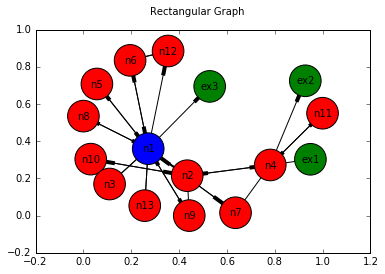

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13']
n1
['edge_n1_n2_000']
moving n1 -> n2


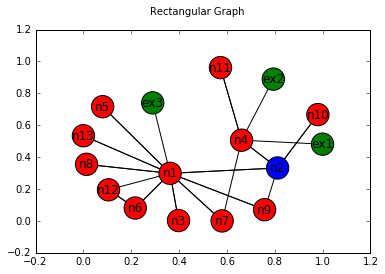

In [98]:
%matplotlib inline
rect_graph.show(descriptions=False)
print rect_graph.state
print rect_graph.node_names
print rect_graph.current_node
rect_graph.move_to_node("n2")
rect_graph.show(font_size=12,node_size=500,arrows=False,save_plot=True)

In [7]:
rect_graph.is_graph_isomorphic()

['edge_n2_n1_000']
moving n2 -> n1
['edge_n1_n2_000']
moving n1 -> n2


True

In [8]:
rect_graph.move_to_node("n2")

['edge_n2_n1_000', 'edge_n1_n2_000']
moving n2 -> n1
moving n1 -> n2


In [7]:
#print rect_graph.data

In [88]:
def DataFrame_to_hdf(pandas_data_frame):
    pandas_data_frame.to_hdf("Test.hdf","table")
    return "Test.hdf"
def hdf_to_DataFrame(hdf_file_name):
    df=pandas.read_hdf(hdf_file_name,"table")
    return df
def XMLDataTable_to_AsciiDataTable(xml_table):
    
    table=AsciiDataTable(None,
                         column_names=xml_table.attribute_names,
                         data=xml_table.data)
    return table
def AsciiDataTable_to_XMLDataTable_2(data_table):
    xml=AsciiDataTable_to_XMLDataTable(data_table)
    return xml
def DataFrame_to_excel(pandas_data_frame,file_name="Test.xlsx"):
    pandas_data_frame.to_excel(file_name,index=False)
    return file_name

def excel_to_DataFrame(excel_file_name):
    df=pandas.read_excel(excel_file_name)
    return df
def DataFrame_to_HTML_string(pandas_data_frame):
    html=pandas_data_frame.to_html(index=False)
    return html

def HTML_string_to_DataFrame(html_string):
    list_df=pandas.read_html(html_string)
    return list_df[0]
def DataFrame_to_json(pandas_data_frame):
    json=pandas_data_frame.to_json("test.json",orient='records')
    return "test.json"

def json_to_DataFrame(json_file_name):
    data_frame=pandas.read_json(json_file_name,orient='records')
    return data_frame

def DataFrame_to_json_string(pandas_data_frame):
    json=pandas_data_frame.to_json(orient='records')
    return json

def json_string_to_DataFrame(json_string):
    data_frame=pandas.read_json(json_string,orient='records')
    return data_frame

def DataFrame_to_csv(pandas_data_frame,file_name="test.csv"):
    csv=pandas_data_frame.to_csv(file_name,index=False)
    return file_name

def csv_to_DataFrame(csv_file_name):
    data_frame=pandas.read_csv(csv_file_name)
    return data_frame

def AsciiDataTable_to_Matlab(ascii_data_table,file_name="test.mat"):
    matlab_data_dictionary={"data":ascii_data_table.data,"column_names":ascii_data_table.column_names}
    savemat(file_name,matlab_data_dictionary)
    return file_name

def Matlab_to_AsciiDataTable(matlab_file_name):
    matlab_data_dictionary=loadmat(matlab_file_name)
    ascii_data_table=AsciiDataTable(None,
                                    column_names=map(lambda x: x.rstrip().lstrip(),
                                                     matlab_data_dictionary["column_names"].tolist()),
                                     data=matlab_data_dictionary["data"].tolist())
    return ascii_data_table

def DataTable_to_XML(xml_data_table,file_name="test.xml"):
    xml_data_table.save(file_name)
    return file_name

def XML_to_DataTable(xml_file_name):
    xml_data_table=DataTable(xml_file_name)
    return xml_data_table

def html_string_to_html_file(html_string,file_name="test.html"):
    out_file=open(file_name,'w')
    out_file.write(html_string)
    out_file.close()
    return file_name
# this is broken, something does not work properly
def html_file_to_pandas(html_file_name):
    in_file=open(html_file_name,'r')
    pandas_data_frame=pandas.read_html(in_file)
    return pandas_data_frame

def html_file_to_html_string(html_file_name):
    in_file=open(html_file_name,'r')
    html_string=in_file.read()
    return html_string

def DataFrame_to_html_file(pandas_data_frame,file_name="test.html"):
    out_file=open(file_name,'w')
    pandas_data_frame.to_html(out_file,index=False)
    return file_name

def json_to_DataTable(json_file_name):
    data_dictionary_list=json.load(open(json_file_name,'r'))
    xml=DataTable(None,data_dictionary={"data":data_dictionary_list})
    return xml

def csv_to_AsciiDataTable(csv_file_name):
    options={"column_names_begin_line":0,"column_names_end_line":1,
             "data_begin_line":1,"data_end_line":-1,"data_delimiter":",","column_names_delimiter":","}
    table=AsciiDataTable(csv_file_name,**options)
    return table

def DataFrame_to_sqlite(pandas_data_frame,file_name="test.db",table_name="data"):
    """Transforms a pandas.DataFrame to a table in an sqlite database"""
#     connection=sqlite3.connect(file_name)
#     connection.close()
    sql_url="sqlite:///{0}::{1}".format(file_name,table_name)
    odo.odo(pandas_data_frame,sql_url)
    return sql_url

def sqlite_to_DataFrame(sqlite_url):
    """Creates a pandas.DataFrame from a table in an sqlite database (use sqlite:///file_name::table_name)"""
    pandas_data_frame=odo.odo(sqlite_url,pandas.DataFrame)
    return pandas_data_frame
def identity(parameter):
    return parameter

In [89]:
# need to rename these Model1_to_Model2
rect_graph.add_node("n3","n1",DataFrame_to_hdf,"n1",hdf_to_DataFrame)
rect_graph.node_descriptions.append("HDF File")
rect_graph.add_node("n4","n2",AsciiDataTable_to_XMLDataTable_2,"n2",XMLDataTable_to_AsciiDataTable)
rect_graph.node_descriptions.append("XML Data Table")

# Need to add XML File and Html File using save and save_HTML()
rect_graph.add_node("n5","n1",DataFrame_to_excel,"n1",excel_to_DataFrame)
rect_graph.node_descriptions.append("Excel File")
rect_graph.add_node("n6","n1",DataFrame_to_HTML_string,"n1",HTML_string_to_DataFrame)
rect_graph.node_descriptions.append("HTML String")

# Note a lot of the pandas reading and writing cause float64 round off errors
# applymap(lambda x: np.around(x,10) any all float fields will fix this
# also the column names move about in order
rect_graph.add_node("n7","n1",DataFrame_to_json,"n1",json_to_DataFrame)
rect_graph.node_descriptions.append("JSON File")
rect_graph.add_node("n8","n1",DataFrame_to_json_string,"n1",json_string_to_DataFrame)
rect_graph.node_descriptions.append("JSON String")
rect_graph.add_node("n9","n1",DataFrame_to_csv,"n1",csv_to_DataFrame)
rect_graph.node_descriptions.append("CSV File")
rect_graph.add_node("n10","n2",AsciiDataTable_to_Matlab,"n2",Matlab_to_AsciiDataTable)
rect_graph.node_descriptions.append("Matlab File")
rect_graph.add_node("n11","n4",DataTable_to_XML,"n4",XML_to_DataTable)
rect_graph.node_descriptions.append("XML File")
rect_graph.add_node("n12","n6",html_string_to_html_file,"n6",html_file_to_html_string)
rect_graph.node_descriptions.append("HTML File")
# rect_graph.add_node("n13","n1",DataFrame_to_sqlite,"n1",sqlite_to_DataFrame)
# rect_graph.node_descriptions.append("sqlite table")
rect_graph.add_node("n13","n1",identity,"n1",identity)
rect_graph.node_descriptions.append("Identity")
rect_graph.add_edge("n1","n12",DataFrame_to_html_file)
rect_graph.add_edge("n7","n4",json_to_DataTable)
rect_graph.add_edge("n9","n2",csv_to_AsciiDataTable)

In [90]:
def jump_to_html_string(xml_data_table,style_sheet=os.path.join(TESTS_DIRECTORY,XSLT_REPOSITORY,"DEFAULT_MEASUREMENT_STYLE.xsl")):
    """Creates a html string from an xml data table"""
    return xml_data_table.to_HTML(style_sheet)
def jump_to_html_file(xml_data_table,style_sheet=os.path.join(TESTS_DIRECTORY,XSLT_REPOSITORY,"DEFAULT_MEASUREMENT_STYLE.xsl"),file_path=None):
    """creates a html file from an xml data table"""
    xml_data_table.save_HTML(style_sheet,file_path=file_path)
    if file_path is None:
        file_path=xml_data_table.path.replace('.xml','.html')
    return file_path
rect_graph.add_external_node("ex1","n4",jump_to_html_string)
rect_graph.external_node_descriptions.append("html_string")
rect_graph.add_external_node("ex2","n4",jump_to_html_file)
rect_graph.external_node_descriptions.append("html_file")
rect_graph.add_external_node("ex3","n1",DataFrame_to_sqlite)
rect_graph.external_node_descriptions.append("Sqlite3")

In [33]:
path=rect_graph.get_path("n1","n11")

In [35]:
new_path=remove_circular_paths(path)

In [36]:
new_path

['edge_n1_n13_000', 'edge_n13_n1_000']

In [50]:
def remove_circular_paths(path):
    """Removes pieces of the path that just end on the same node"""
    edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
    past_locations=[]
    
    for index,edge in enumerate(path):
        match=re.match(edge_pattern,edge)
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        past_locations.append(begin_node)
        #print("{0} is {1}".format("past_locations",past_locations))
    new_path=[]
    node_index=0
    between_list=[False for item in past_locations]
    while(node_index<len(past_locations)):
        node=past_locations[node_index]
        old_path=new_path
        new_path=[]
        
        if past_locations.count(node)>1:
            print("{0} is {1}".format("node",node))
            print("{0} is {1}".format("past_locations",past_locations))
            equality_list=map(lambda x:x==node,past_locations)
            print("{0} is {1}".format("equality_list",equality_list))
            between=False
            for index,equality in enumerate(equality_list):
                if equality and equality_list[index:].count(True)%2==1:
                    between=not between
                    between_list[index]=between or between_list[index]
                else:
                    between_list[index]=between or between_list[index] 
        print("{0} is {1}".format("between_list",between_list))
        for index,item in enumerate(between_list):
            if not item:
                new_path.append(path[index])
        node_index+=1

    if new_path in [[]]:
        new_path=path
                    
    return new_path
print path
print remove_circular_paths(path)

['edge_n1_n12_000', 'edge_n12_n6_000', 'edge_n6_n1_000', 'edge_n1_n13_000', 'edge_n13_n1_000', 'edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
node is n1
past_locations is ['n1', 'n12', 'n6', 'n1', 'n13', 'n1', 'n9', 'n2', 'n4']
equality_list is [True, False, False, True, False, True, False, False, False]
between_list is [True, True, True, True, True, False, False, False, False]
between_list is [True, True, True, True, True, False, False, False, False]
between_list is [True, True, True, True, True, False, False, False, False]
node is n1
past_locations is ['n1', 'n12', 'n6', 'n1', 'n13', 'n1', 'n9', 'n2', 'n4']
equality_list is [True, False, False, True, False, True, False, False, False]
between_list is [True, True, True, True, True, False, False, False, False]
between_list is [True, True, True, True, True, False, False, False, False]
node is n1
past_locations is ['n1', 'n12', 'n6', 'n1', 'n13', 'n1', 'n9', 'n2', 'n4']
equality_list is [True, False, False, True,

In [49]:
3%2

1

In [12]:
html_file_name=rect_graph.jump_to_external_node("ex2")

['edge_n2_n4_000']
moving n2 -> n4


In [13]:
rect_graph.jumps

['jump_n4_ex1_000', 'jump_n4_ex2_000']

<IPython.core.display.Javascript object>


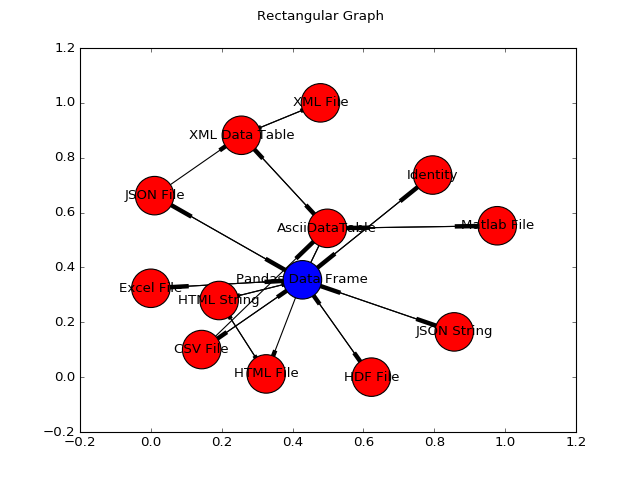

In [84]:
%matplotlib notebook
rect_graph.show(descriptions=True,font_size=12,node_size=1200)

In [86]:
class ColumnModeledGraph(Graph):
    """Class that transforms column modeled data from one format to another, use set_state to intialize to
    your data"""
    def __init__(self,**options):
        defaults={"graph_name":"Column Modeled Graph",
                  "node_names":['n1','n2'],
                  "node_descriptions":["Pandas Data Frame","AsciiDataTable"],
                  "current_node":'n1',
                  "state":[1,0],
                  "data":pandas.DataFrame([[1,2,3],[3,4,5]],columns=["a","b","c"]),
                  "edge_2_to_1":AsciiDataTable_to_DataFrame,
                  "edge_1_to_2":DataFrame_to_AsciiDataTable}
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        Graph.__init__(self,**self.options)
        self.add_node("n3","n1",DataFrame_to_hdf,"n1",hdf_to_DataFrame)
        self.node_descriptions.append("HDF File")
        self.add_node("n4","n2",AsciiDataTable_to_XMLDataTable_2,"n2",XMLDataTable_to_AsciiDataTable)
        self.node_descriptions.append("XML Data Table")
        
        # Need to add XML File and Html File using save and save_HTML()
        self.add_node("n5","n1",DataFrame_to_excel,"n1",excel_to_DataFrame)
        self.node_descriptions.append("Excel File")
        self.add_node("n6","n1",DataFrame_to_HTML_string,"n1",HTML_string_to_DataFrame)
        self.node_descriptions.append("HTML String")
        
        # Note a lot of the pandas reading and writing cause float64 round off errors
        # applymap(lambda x: np.around(x,10) any all float fields will fix this
        # also the column names move about in order
        self.add_node("n7","n1",DataFrame_to_json,"n1",json_to_DataFrame)
        self.node_descriptions.append("JSON File")
        self.add_node("n8","n1",DataFrame_to_json_string,"n1",json_string_to_DataFrame)
        self.node_descriptions.append("JSON String")
        self.add_node("n9","n1",DataFrame_to_csv,"n1",csv_to_DataFrame)
        self.node_descriptions.append("CSV File")
        self.add_node("n10","n2",AsciiDataTable_to_Matlab,"n2",Matlab_to_AsciiDataTable)
        self.node_descriptions.append("Matlab File")
        self.add_node("n11","n4",DataTable_to_XML,"n4",XML_to_DataTable)
        self.node_descriptions.append("XML File")
        self.add_node("n12","n6",html_string_to_html_file,"n6",html_file_to_html_string)
        self.node_descriptions.append("HTML File")
        self.add_edge("n1","n12",DataFrame_to_html_file)
        self.add_edge("n7","n4",json_to_DataTable)
        self.add_edge("n9","n2",csv_to_AsciiDataTable)
        
    

In [91]:
rect_graph.is_graph_isomorphic()

['edge_n1_n2_000', 'edge_n2_n1_000']
moving n1 -> n2
moving n2 -> n1
['edge_n1_n2_000']
moving n1 -> n2
['edge_n2_n1_000', 'edge_n1_n3_000']
moving n2 -> n1
moving n1 -> n3
['edge_n3_n1_000', 'edge_n1_n2_000', 'edge_n2_n4_000']
moving n3 -> n1
moving n1 -> n2
moving n2 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000']
moving n4 -> n11
moving n11 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000']
moving n4 -> n11
moving n11 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000']
moving n4 -> n11
moving n11 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000']
moving n4 -> n11
moving n11 -> n4
['edge_n4_n11_000', 'edge_n11_n4_000']
moving n4 -> n11
moving n11 -> n4
['edge_n4_n2_000', 'edge_n2_n10_000']
moving n4 -> n2
moving n2 -> n10
['edge_n10_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
moving n10 -> n2
moving n2 -> n4
moving n4 -> n11
['edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n12_000']
moving n11 -> n4
moving n4 -> n2
moving n2 -> n1
moving n1 -> n12
['edge_n12_n6_000', 'edge_n6_n1_000', 'e

True

In [127]:
transform=ColumnModeledGraph(data=data_frame)

In [128]:
transform.get_description_dictionary()

{'n1': 'Pandas Data Frame',
 'n10': 'Matlab File',
 'n11': 'XML File',
 'n12': 'HTML File',
 'n2': 'AsciiDataTable',
 'n3': 'HDF File',
 'n4': 'XML Data Table',
 'n5': 'Excel File',
 'n6': 'HTML String',
 'n7': 'JSON File',
 'n8': 'JSON String',
 'n9': 'CSV File'}

In [51]:
transform.set_state(node_data="test.xlsx",node_name="n5")

In [122]:
data=csv_to_AsciiDataTable(transform.data)

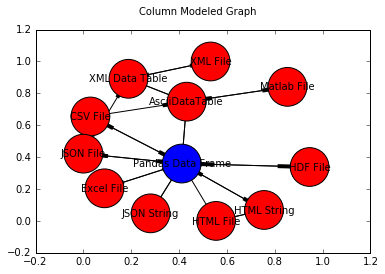

In [129]:
transform.show(descriptions=True)

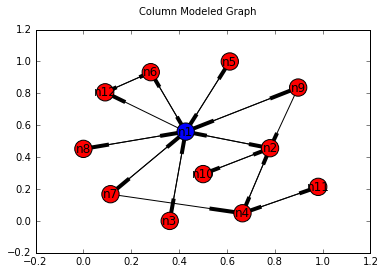

In [130]:
transform.show(descriptions=False)

In [15]:
rect_graph.move_to_node("n3")

['edge_n2_n1_000', 'edge_n1_n3_000']
moving n2 -> n1
moving n1 -> n3


In [703]:
rect_graph.get_entering_edges("n12")

['edge_n6_n12_000', 'edge_n1_n12_000']

In [8]:
path=rect_graph.get_path("n11","n12")

In [621]:
rect_graph.get_exiting_edges("n1")

['edge_n1_n2_000',
 'edge_n1_n3_000',
 'edge_n1_n5_000',
 'edge_n1_n6_000',
 'edge_n1_n7_000',
 'edge_n1_n8_000',
 'edge_n1_n9_000',
 'edge_n1_n12_000']

In [705]:
path=rect_graph.get_path("n11","n12")

next_edge was already in path


In [120]:
rect_graph.get_path("n9","n2")

['edge_n9_n1_000', 'edge_n1_n2_000']

In [9]:
path

['edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n12_000']

In [544]:
def remove_circular_paths(path):
    """Removes pieces of the path that just end on the same node"""
    edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")
    past_locations=[]
    
    for index,edge in enumerate(path):
        match=re.match(edge_pattern,edge)
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        past_locations.append(begin_node)
        #print("{0} is {1}".format("past_locations",past_locations))
    new_path=[]
    node_index=0
    between_list=[False for item in past_locations]
    while(node_index<len(past_locations)):
        node=past_locations[node_index]
        old_path=new_path
        new_path=[]
        
        if past_locations.count(node)>1:
            equality_list=map(lambda x:x==node,past_locations)
            between=False
            for index,equality in enumerate(equality_list):
                if equality:
                    between=not between
                    between_list[index]=between or between_list[index]
                else:
                    between_list[index]=between or between_list[index] 
        #print("{0} is {1}".format("between_list",between_list))
        for index,item in enumerate(between_list):
            if not item:
                new_path.append(path[index])
        node_index+=1

    if new_path in [[]]:
        new_path=path
                    
    return new_path

In [498]:
test_nodes=["n4","n11","n4","n2","n1","n5"]
print test_nodes.count("n4")
print test_nodes.index("n4")
#del test_nodes[0:2]
truth_list=map(lambda x:x=="n4",test_nodes)
out_list=[]
non_circular=[]
between=False
for index,truth in enumerate(truth_list):
    if truth:
        between=not between
        out_list.append(between)
    else:
        out_list.append(between)
for index,item in enumerate(out_list):
    if not item:
        non_circular.append(test_nodes[index])
    
print out_list
print non_circular

2
0
[True, True, False, False, False, False]
['n4', 'n2', 'n1', 'n5']


In [545]:
print remove_circular_paths(['edge_n4_n11_000',
 'edge_n11_n4_000',
 'edge_n4_n2_000',
 'edge_n2_n1_000',
 'edge_n1_n5_000','edge_n5_n1_000',
 'edge_n1_n5_000'])

between_list is [True, True, False, False, False, False, False]
between_list is [True, True, False, False, False, False, False]
between_list is [True, True, False, False, False, False, False]
between_list is [True, True, False, False, False, False, False]
between_list is [True, True, False, False, True, True, False]
between_list is [True, True, False, False, True, True, False]
between_list is [True, True, False, False, True, True, False]
['edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n5_000']


In [258]:
rect_graph.move_to(path)

['edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n5_000']
moving n4 -> n2
moving n2 -> n1
moving n1 -> n5


In [117]:
rect_graph.move_to_node("n2")

['edge_n9_n1_000', 'edge_n1_n2_000']
moving n9 -> n1
moving n1 -> n2


In [ ]:
xml=AsciiDataTable_to_XMLDataTable(table)

In [ ]:
xml.to_tuple_list(xml.get_attribute_names())

In [ ]:
xml.to_list("a")

In [ ]:
xml.attribute_names

In [ ]:
xml.data

In [ ]:
rect_graph.state

In [ ]:
path=rect_graph.get_path("n5","n1")

In [ ]:
rect_graph.path_length(path)

In [ ]:
rect_graph.move_to_node("n1")

In [8]:
path=['edge_n1_n12_000', 'edge_n12_n6_000', 'edge_n6_n1_000', 'edge_n1_n13_000', 'edge_n13_n1_000', 'edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
print remove_circular_paths(path)

['edge_n1_n13_000', 'edge_n13_n1_000']


In [92]:
rect_graph.move_to_node("n1")
for node in rect_graph.node_names:
    path=rect_graph.get_path("n1",node)
    print(path)
    print("The length of the path n1-> {0} in s is {1}".format(node,rect_graph.path_length(path)))

['edge_n13_n1_000']
moving n13 -> n1
['edge_n1_n2_000', 'edge_n2_n1_000']
The length of the path n1-> n1 in s is 0.016
['edge_n1_n2_000']
The length of the path n1-> n2 in s is 0.0135
['edge_n1_n3_000']
The length of the path n1-> n3 in s is 0.0087
['edge_n1_n2_000', 'edge_n2_n4_000']
The length of the path n1-> n4 in s is 0.0758
['edge_n1_n5_000']
The length of the path n1-> n5 in s is 0.1257
['edge_n1_n6_000']
The length of the path n1-> n6 in s is 0.1153
['edge_n1_n7_000']
The length of the path n1-> n7 in s is 0.0052
['edge_n1_n8_000']
The length of the path n1-> n8 in s is 0.0005
['edge_n1_n9_000']
The length of the path n1-> n9 in s is 0.0088
['edge_n1_n2_000', 'edge_n2_n10_000']
The length of the path n1-> n10 in s is 0.0152
['edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
The length of the path n1-> n11 in s is 0.107
['edge_n1_n6_000', 'edge_n6_n12_000']
The length of the path n1-> n12 in s is 0.122
['edge_n1_n13_000']
Warning the path length is less th

In [28]:
path=rect_graph.get_path("n1","n11")

['edge_n1_n13_000', 'edge_n13_n1_000']

In [12]:
path=['edge_n1_n12_000', 'edge_n12_n6_000', 
 'edge_n6_n1_000', 'edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
print remove_circular_paths(path)

['edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']


In [115]:
rect_graph.move_to_node("n4")

['edge_n7_n4_000']
moving n7 -> n4


In [ ]:
html=rect_graph.data.to_html(index=False)

In [ ]:
df=pandas.read_html(html)

In [ ]:
rect_graph.edges

In [ ]:
table=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))
rect_graph.set_state("n2",table)

In [113]:
rect_graph.move_to_node("n7")

['edge_n2_n1_000', 'edge_n1_n7_000']
moving n2 -> n1
moving n1 -> n7


In [ ]:
print rect_graph.data

In [ ]:
from ipywidgets import *


['edge_n4_n11_000', 'edge_n11_n4_000', 'edge_n4_n2_000', 'edge_n2_n1_000', 'edge_n1_n3_000']
moving n4 -> n11
moving n11 -> n4
moving n4 -> n2
moving n2 -> n1
moving n1 -> n3
********************************************************************************
HDF File [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
********************************************************************************


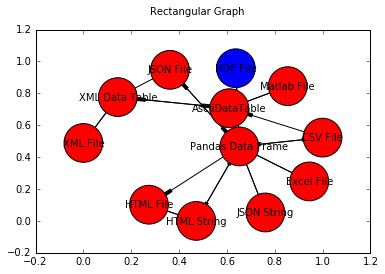

In [111]:
%matplotlib inline
rect_graph.move_to_node("n1")
def move_and_show(end_node_number):
    node=rect_graph.node_names[end_node_number]
    rect_graph.move_to_node(node)
    print("*"*80)
    print("{0}".format(rect_graph.node_descriptions[end_node_number])+" {0}".format(rect_graph.state))
    print("*"*80)
    rect_graph.show(descriptions=True)
    
interact(move_and_show,end_node_number=(0,len(rect_graph.node_names)-1,1))

In [19]:
def move_and_print(end_node_number):
    node=rect_graph.node_names[end_node_number]
    rect_graph.move_to_node(node)
    print("*"*80)
    print("{0}".format(rect_graph.node_descriptions[end_node_number])+" {0}".format(rect_graph.state))
    print("*"*80)
    print rect_graph.data
    
interact(move_and_print,end_node_number=(0,len(rect_graph.node_names)-1,1))

['edge_n12_n6_000', 'edge_n6_n1_000', 'edge_n1_n9_000', 'edge_n9_n2_000', 'edge_n2_n4_000', 'edge_n4_n11_000']
moving n12 -> n6
moving n6 -> n1
moving n1 -> n9
moving n9 -> n2
moving n2 -> n4
moving n4 -> n11
********************************************************************************
XML File [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
********************************************************************************
test.xml


In [ ]:
json=data_frame.to_json("test.json",orient='records')

In [ ]:
json_string=data_frame.to_json(orient='records')

In [ ]:
new_df=pandas.read_json(json_string,orient='records')

In [ ]:
new_df=pandas.read_json("test.json",orient='records')

In [ ]:
#str(table.get_data_dictionary_list())
json

In [ ]:
rect_graph.node_descriptions


In [ ]:
import json
test_list=json.load(open("test.json",'r'))

In [ ]:
text_xml=DataTable(None,**{"data_dictionary":{"data":test_list}})

In [ ]:
#print text_xml

In [ ]:
rect_graph.edges

In [ ]:
rect_graph.move_to_node("n7")

In [ ]:
rect_graph.move_to_node("n4")

In [ ]:
#print rect_graph.data

In [ ]:
from scipy.io import savemat,loadmat

In [ ]:
savemat("data.mat",{"data":table.data,"column_names":table.column_names})

In [ ]:
data=loadmat("data.mat")

In [ ]:
new_table=AsciiDataTable(None,column_names=map(lambda x: x.rstrip().lstrip(),data["column_names"].tolist()),
                         data=data["data"].tolist())

In [ ]:
rect_graph.move_to_node("n4")
xml=rect_graph.data

In [ ]:
import sqlite3
import odo

In [ ]:
data_frame.dtypes[0]

In [ ]:
conn = sqlite3.connect("test.db")
conn.execute("create table data")
odo.odo(data_frame,'sqlite:///test.db::data')

In [15]:
one_port=OnePortCalrepModel(os.path.join(TESTS_DIRECTORY,'700437.asc'))

The self.metadata["Device_Id"] variable is 700437


In [ ]:
one_port.header

In [ ]:
one_port.column_names

In [18]:
one_port.metadata

{'Analysis_Date': '16-Oct-15', 'Device_Id': '700437'}

In [19]:
for element in one_port.elements:
    print element

header
column_names
data
footer
inline_comments
metadata


In [ ]:
header_table=pandas.DataFrame(one_port.header,columns=["Header_Line_Content"])
data_table=pandas.DataFrame(one_port.data,columns=one_port.column_names)
footer_table=pandas.DataFrame(one_port.footer,columns=["Footer_Line_Content"])
inline_comments=pandas.DataFrame(one_port.footer,columns=["Line","Location","Comment"])
metadata_table=pandas.DataFrame([[key,value] for key,value in one_port.metadata.iteritems() ], 
                                columns=["Property","Value"])

In [ ]:
header_table

In [129]:
# Move this to a DataTable Graph Example
def AsciiDataTable_to_DataFrame_dict(AsciiDataTable):
    """Converts an AsciiDataTable to a dictionary of pandas.DataFrame s"""
    output_dict={}
    for element in AsciiDataTable.elements:
        #print("{0} is {1}".format('element',element))
        if AsciiDataTable.__dict__[element]:
            if re.search('header',element,re.IGNORECASE):
                header_table=pandas.DataFrame(AsciiDataTable.header,columns=["Header_Line_Content"])
                output_dict["Header"]=header_table
            # needs to be before data search    
            elif re.search('meta',element,re.IGNORECASE):
                #print("{0} is {1}".format('element',element))
                metadata_table=pandas.DataFrame([[key,value] for key,value in AsciiDataTable.metadata.iteritems()], 
                                columns=["Property","Value"])
                output_dict["Metadata"]=metadata_table    
            elif re.search('data|^meta',element,re.IGNORECASE):
                
                data_table=pandas.DataFrame(AsciiDataTable.data,columns=AsciiDataTable.column_names)
                output_dict["Data"]=data_table
                
            elif re.search('footer',element,re.IGNORECASE):
                footer_table=pandas.DataFrame(AsciiDataTable.footer,columns=["Footer_Line_Content"])
                output_dict["Footer"]=footer_table
                
            elif re.search('comment',element,re.IGNORECASE):
                comments=AsciiDataTable.__dict__[element]
                inline_comments=pandas.DataFrame(comments,columns=["Comment","Line","Location"])
                output_dict["Comments"]=inline_comments
    return output_dict

def DataFrame_dict_to_AsciiDataTable(DataFrame_dict,**options):
    """Given a dictionary of pandas DataFrames returns an AsciiDataTable"""
    defaults={"inline_comment_begin":"!","inline_comment_end":"\n"}
    table_options={}
    for key,value in defaults.iteritems():
        table_options[key]=value
    for key,value in options.iteritems():
        table_options[key]=value
    keys=DataFrame_dict.keys()
    for key in keys:
        table_key=key
        if key in["comments","Comments","inline_comments","Inline_Comments"]:
            table_key="inline_comments"
        if key in ["data","Data"]:
            table_options["column_names"]=DataFrame_dict[key].columns.tolist()
            
        table_options[table_key.lower()]=DataFrame_dict[key].as_matrix().tolist()
    new_table=AsciiDataTable(None,**table_options)
    return new_table
        
    

In [43]:
panda_dict=AsciiDataTable_to_DataFrame_dict(one_port)

In [44]:
panda_dict["Metadata"]

,Property,Value
0,Analysis_Date,16-Oct-15
1,Device_Id,700437


In [46]:
#panda_dict["Data"]

In [107]:
def DataFrame_dict_to_excel(DataFrame_dict,excel_file_name="Test.xlsx"):
    """Converts a dictionary of pandas DataFrames to a single excel file with sheet names
    determined by keys"""
    # sort the keys so that they will display in the same order
    writer = pandas.ExcelWriter(excel_file_name)
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        #print key
        DataFrame_dict[key].to_excel(writer,sheet_name=key,index=False)
    writer.close()
    return excel_file_name

def excel_to_DataFrame_dict(excel_file_name):
    """Reads an excel file into a dictionary of data frames"""
    data_frame_dictionary=pandas.read_excel(excel_file_name,sheetname=None)
    return data_frame_dictionary

def DataFrame_dict_to_hdf(DataFrame_dict,hdf_file_name="Test.hd5"):
    """Transforms a dictionary of pandas.DataFrames to a single HD5 file with groups determined by the keys"""
    keys=sorted(DataFrame_dict.keys())
    for key in keys:
        DataFrame_dict[key].to_hdf(hdf_file_name,key)
    return hdf_file_name

def hdf_to_DataFrame_dict(hdf_file_name):
    """Creates a dictionary of pandas.DataFrames given a hd5 file name, does this require the table names?
    """
    hdf=h5py.File(hdf_file_name)
    keys=hdf.keys()
    pandas_dictionary={key:pandas.read_hdf(hdf_file_name,key) for key in keys}
    return pandas_dictionary
    

In [ ]:
DataFrame_dict_to_excel(panda_dict)

In [ ]:
test_dict=pandas.read_excel("Test.xlsx",sheetname=None)

In [ ]:
test_dict["Header"]

In [48]:
raw_table=TwoPortRawModel(os.path.join(TESTS_DIRECTORY,'TestFileTwoPortRaw.txt'))

In [49]:
test_dict=AsciiDataTable_to_DataFrame_dict(raw_table)

In [50]:
test_dict.keys()

['Header', 'Data', 'Metadata']

In [40]:
test_dict["Metadata"]

,Property,Value
0,Connector_Type_Calibration,
1,Number_Connects,3
2,Connector_Type_Measurement,N
3,Number_Repeats,1
4,Operator,BFR
5,Number_Frequencies,53
6,Start_Frequency,7
7,Measurement_Date,9 Sep 2015
8,Program_Used,MEASLP
9,Measurement_Type,2-port


In [41]:
test_dict["Header"]

,Header_Line_Content
0,HP8510
1,L
2,
3,N
4,2-port
5,9 Sep 2015
6,10:31:55
7,MEASLP
8,150122
9,BFR


In [53]:
excel=DataFrame_dict_to_excel(test_dict)

In [56]:
s2p=S2PV1(os.path.join(TESTS_DIRECTORY,'704b.S2P'))

In [67]:
test_dict=AsciiDataTable_to_DataFrame_dict(s2p)

In [60]:
s2p.comments

[['---------------------------------------------------------------------',
  0,
  0],
 [' ZVC, 3.52', 1, 0],
 ['---------------------------------------------------------------------',
  2,
  0],
 [' symbol freq-unit parameter-type data-format keyword impedance-ohm', 3, 0],
 ['---------------------------------------------------------------------',
  5,
  0],
 [' freq                dbS11          angS11          dbS21          angS21          dbS12          angS12          dbS22          angS22          ',
  6,
  0]]

In [68]:
excel=DataFrame_dict_to_excel(test_dict)

In [73]:
tet_dict=excel_to_DataFrame_dict("test.xlsx")

In [79]:
test_dict.keys()

['Data', 'Comments']

In [81]:
test_hd5=DataFrame_dict_to_hd5(test_dict)

In [100]:
import h5py
hdf=h5py.File("Test.hd5")
keys=hdf.keys()
pandas_dictionary={key:pandas.read_hdf("Test.hd5",key) for key in keys}

In [103]:
hdf.keys()

[u'Comments', u'Data']

In [108]:
pandas_dictionary=hdf_to_DataFrame_dict("Test.hd5")

In [109]:
pandas_dictionary.keys()

[u'Data', u'Comments']

In [112]:
pandas_dictionary["Comments"].as_matrix().tolist()

[['---------------------------------------------------------------------',
  0L,
  0L],
 [' ZVC, 3.52', 1L, 0L],
 ['---------------------------------------------------------------------',
  2L,
  0L],
 [' symbol freq-unit parameter-type data-format keyword impedance-ohm',
  3L,
  0L],
 ['---------------------------------------------------------------------',
  5L,
  0L],
 [' freq                dbS11          angS11          dbS21          angS21          dbS12          angS12          dbS22          angS22          ',
  6L,
  0L]]

In [130]:
table=DataFrame_dict_to_AsciiDataTable(pandas_dictionary)

In [134]:
#print table.get_data_string()

In [138]:
rect_graph.node_names

['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10']

In [139]:
new_graph=networkx.DiGraph()

In [333]:
for node in rect_graph.node_names:
    new_graph.add_node(node)

In [141]:
rect_graph.edges

['edge_n1_n2_000',
 'edge_n2_n1_000',
 'edge_n3_n1_000',
 'edge_n1_n3_000',
 'edge_n4_n2_000',
 'edge_n2_n4_000',
 'edge_n5_n1_000',
 'edge_n1_n5_000',
 'edge_n6_n1_000',
 'edge_n1_n6_000',
 'edge_n7_n1_000',
 'edge_n1_n7_000',
 'edge_n8_n1_000',
 'edge_n1_n8_000',
 'edge_n9_n1_000',
 'edge_n1_n9_000',
 'edge_n10_n2_000',
 'edge_n2_n10_000',
 'edge_n7_n4_000']

In [143]:
edge_pattern=re.compile("edge_(?P<begin_node>\w+)_(?P<end_node>\w+)_(?P<iterator>\w+)")

In [332]:
for edge in rect_graph.edges:
    match=re.match(edge_pattern,edge)
    if match:
        begin_node=match.groupdict()["begin_node"]
        end_node=match.groupdict()["end_node"]
        new_graph.add_edge(begin_node,end_node)
        print("Begin Node = {0}, End Node= {1}".format(begin_node,end_node))

Begin Node = n1, End Node= n2
Begin Node = n2, End Node= n1
Begin Node = n3, End Node= n1
Begin Node = n1, End Node= n3
Begin Node = n4, End Node= n2
Begin Node = n2, End Node= n4
Begin Node = n5, End Node= n1
Begin Node = n1, End Node= n5
Begin Node = n6, End Node= n1
Begin Node = n1, End Node= n6
Begin Node = n7, End Node= n1
Begin Node = n1, End Node= n7
Begin Node = n8, End Node= n1
Begin Node = n1, End Node= n8
Begin Node = n9, End Node= n1
Begin Node = n1, End Node= n9
Begin Node = n10, End Node= n2
Begin Node = n2, End Node= n10
Begin Node = n11, End Node= n4
Begin Node = n4, End Node= n11
Begin Node = n7, End Node= n4


In [150]:
networkx.draw_networkx(new_graph,arrows=True)
plt.show()

<IPython.core.display.Javascript object>


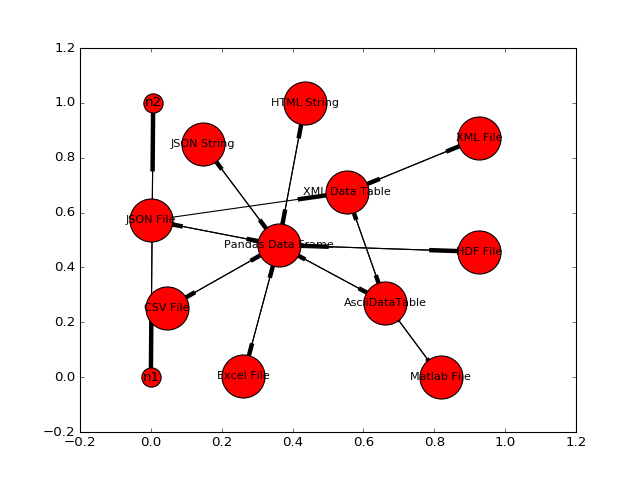

In [334]:
%matplotlib notebook
networkx.draw_networkx(new_graph,arrows=True,
                       labels={node:rect_graph.node_descriptions[index] for index, 
                               node in enumerate(rect_graph.node_names)},node_size=1500,font_size=10)


In [7]:
def html_file_to_pandas(html_file_name):
    in_file=open(html_file_name,'r')
    pandas_data_frame=pandas.read_html(in_file,header=0)
    return pandas_data_frame

In [33]:
df=pandas.read_csv("test.csv")

In [26]:
df.columns


Index([u'Frequency', u'argS11', u'magS11', u'uAa', u'uAb', u'uAd', u'uAg',
       u'uMa', u'uMb', u'uMd', u'uMg'],
      dtype='object')

In [735]:
df.columns


AttributeError: 'list' object has no attribute 'columns'

In [10]:
import lxml

In [17]:
import sqlite3
connection=sqlite3.connect('test.db')

In [18]:
cursor=connection.cursor()

In [21]:
import odo

In [96]:
def DataFrame_to_sqlite(pandas_data_frame,file_name="test.db",table_name="data"):
    """Transforms a pandas.DataFrame to a table in an sqlite database"""
    connection=sqlite3.connect(file_name)
    sql_url="sqlite:///{0}::{1}".format(file_name,table_name)
    odo.odo(pandas_data_frame,sql_url)
    return sql_url

def sqlite_to_DataFrame(sqlite_url):
    """Creates a pandas.DataFrame from a table in an sqlite database (use sqlite:///file_name::table_name)"""
    pandas_data_frame=pandas.DataFrame()
    odo.odo(sqlite_url,pandas_data_frame)
    return pandas_data_frame

In [34]:
odo.odo(df,'sqlite:///test.db::data')

Table('data', MetaData(bind=Engine(sqlite:///test.db)), Column('Frequency', FLOAT(), table=<data>, nullable=False), Column('argS11', FLOAT(), table=<data>, nullable=False), Column('magS11', FLOAT(), table=<data>, nullable=False), Column('uAa', FLOAT(), table=<data>, nullable=False), Column('uAb', FLOAT(), table=<data>, nullable=False), Column('uAd', FLOAT(), table=<data>, nullable=False), Column('uAg', FLOAT(), table=<data>, nullable=False), Column('uMa', FLOAT(), table=<data>, nullable=False), Column('uMb', FLOAT(), table=<data>, nullable=False), Column('uMd', FLOAT(), table=<data>, nullable=False), Column('uMg', FLOAT(), table=<data>, nullable=False), schema=None)

In [29]:
out=cursor.execute("SELECT * FROM data")

In [35]:
new_data_frame=odo.odo('sqlite:///test.db::data',pandas.DataFrame)

In [37]:
ascii=DataFrame_to_AsciiDataTable(new_data_frame)

In [97]:
df=sqlite_to_DataFrame('sqlite:///test.db::data')

TypeError: target of <class 'pandas.core.frame.DataFrame'> type does not support in-place append

In [95]:
df

pandas.core.frame.DataFrame